# ASSIGNMENT 1 (adapted from https://bit.ly/2J7G9f8)

## PROBLEM:

### Context

Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people.

In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.

Submissions in this challenge will take the form of Python data analysis.

Kiva has provided a dataset of loans issued over the 2014-2018 time period, and participants are invited to use this data as well as source external public datasets to help Kiva build models for assessing borrower welfare levels. With a stronger understanding of their borrowers and their poverty levels, Kiva will be able to better assess and maximize the impact of their work.


### Problem statement

For the locations in which Kiva has active loans, the objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.

A good solution would connect the features of each loan or product to one of several poverty mapping datasets, which indicate the average level of welfare in a region on as granular a level as possible. Many datasets indicate the poverty rate in a given area, with varying levels of granularity. Kiva would like to be able to disaggregate these regional averages by gender, sector, or borrowing behavior in order to estimate a Kiva borrower’s level of welfare using all of the relevant information about them. Strong submissions will attempt to map vaguely described locations to more accurate geocodes.

### Personal disclaimer

From a research perspective, the results obtained are never going to be a full representation of the realities that borrowers experience. It is meant to spark a discussion around how we can identify the welfare level of borrowers and improve them where we can.

## SOLUTION:

### Python Packages & Functions

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:
# Packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import re

hide_toggle()

### Data
*Here we upload all the Python packages and datasets required for analysis*

#### 1. Original Data

In [3]:
# Original Data
loan_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//kiva_loans.csv')
location_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//kiva_mpi_region_locations.csv')
loan_themes  = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//loan_theme_ids.csv')
regional_lts = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//loan_themes_by_region.csv')

print('loan_data shape:',loan_data.shape)
print(loan_data.dtypes)
print('')
print('location_data shape:',location_data.shape)
print(location_data.dtypes)
print('')
print('loan_themes shape:',loan_themes.shape)
print(loan_themes.dtypes)
print('')
print('regional_lts shape:',regional_lts.shape)
print(regional_lts.dtypes)

hide_toggle()

loan_data shape: (671205, 20)
id                      int64
funded_amount         float64
loan_amount           float64
activity               object
sector                 object
use                    object
country_code           object
country                object
region                 object
currency               object
partner_id            float64
posted_time            object
disbursed_time         object
funded_time            object
term_in_months        float64
lender_count            int64
tags                   object
borrower_genders       object
repayment_interval     object
date                   object
dtype: object

location_data shape: (2772, 9)
LocationName     object
ISO              object
country          object
region           object
world_region     object
MPI             float64
geo              object
lat             float64
lon             float64
dtype: object

loan_themes shape: (779092, 4)
id                   int64
Loan Theme ID       object
Loan The

##### Descriptions of the original datasets

There are four data sources provided by Kiva:

* ***loan_data***
   1. **id** - Unique ID for loan
   2. **funded_amount** - The amount disbursed by Kiva to the field agent(USD)
   3. **loan_amount** - The amount disbursed by the field agent to the borrower(USD)
   4. **activity** - More granular category
   5. **sector** - High level category
   6. **use** - Exact usage of loan amount
   7. **country_code** - ISO country code of country in which loan was disbursed
   8. **country** - Full country name of country in which loan was disbursed
   9. **region** - Full region name within the country
   10. **currency** - The currency in which the loan was disbursed
   11. **partner_id** - ID of partner organization
   12. **posted_time** - The time at which the loan is posted on Kiva by the field agent
   13. **disbursed_time** - The time at which the loan is disbursed by the field agent to the borrower
   14. **funded_time** - The time at which the loan posted to Kiva gets funded by lenders completely
   15. **term_in_months** - The duration for which the loan was disbursed in months
   16. **lender_count** - The total number of lenders that contributed to this loan
   17. **tags**
   18. **borrower_genders** - Comma separated M,F letters, where each instance represents a single male/female in the group
   19. **repayment_interval**
   20. **date**
   
####  

* ***location_data***
   1. **LocationName** - region, country
   2. **ISO** - some sort of unique abbreviation for country   
   3. **country** - country   
   4. **region** - region within country   
   5. **world_region** - parts of the world   
   6. **MPI** - multidimensional poverty index   
   7. **geo** - (latitude, longitude)
   8. **lat** - latitude   
   9. **lon** - longitude
   
####  

* ***loan_themes***
   1. **id** - Unique ID for loan (Loan ID)   
   2. **Loan Theme ID** - ID for Loan Theme   
   3. **Loan Theme Type** - Category name of type of loan   
   4. **Partner ID**
   
####  

* ***regional_lts***
   1. **Partner ID**   
   2. **Field Partner Name**
   3. **sector**
   4. **Loan Theme ID**
   5. **Loan Theme Type**  
   6. **country**   
   7. **forkiva**   
   8. **region**
   9. **geocode_old**   
   10. **ISO**   
   11. **number**
   12. **amount**
   13. **LocationName**
   14. **geocode**
   15. **names**
   16. **geo**
   17. **lat**
   18. **lon**
   19. **mpi_region**
   20. **mpi_geo**
   21. **rural_pct**

#### 2. Supplementary Data

In this section, we aim to gather the following data from the World Bank:

1. [Per Capita Expenditure (PCE)](https://www.quora.com/What-does-per-capita-expenditure-mean?share=1) for each country - *this is the total market value of all purchases in a country divided by that country's total population* (data: https://bit.ly/3blw0be)
2. [Multidimensional poverty headcount ratio](https://duckduckgo.com/?t=ffab&q=headcount+ratio+meaning&ia=web) - *this is the proportion of a country's population that lives, below the poverty line.* (data: https://bit.ly/2VfM2hi)
3. [GDP per capita (2011 PPP)](http://hdr.undp.org/en/content/gdp-per-capita-2011-ppp) for each country - *this is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products, expressed in international dollars using purchasing power parity rates and divided by total population of the same period.*

In [4]:
# Per Capita Expenditure
PCE_data = pd.read_html('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//PCE data.html')
PCE_data = PCE_data[0]
PCE_data = pd.DataFrame(PCE_data)

# World Bank Gross data
db_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//Data_Extract_From_Poverty_and_Equity//806b9aec-08c0-45f0-8acc-e02a84ec7c9c_Data.csv')

print('PCE_data shape:',PCE_data.shape)
print(PCE_data.dtypes)
print('')
print('db_data shape:',db_data.shape)
print(db_data.dtypes)
print(db_data.iloc[:,0].unique())

hide_toggle()

PCE_data shape: (185, 61)
Unnamed: 0      object
1960            object
1961            object
1962            object
1963            object
                ...   
2015           float64
2016           float64
2017           float64
2018           float64
Unnamed: 60    float64
Length: 61, dtype: object

db_data shape: (560, 50)
Series Name      object
Series Code      object
Country Name     object
Country Code     object
1974 [YR1974]    object
1975 [YR1975]    object
1976 [YR1976]    object
1977 [YR1977]    object
1978 [YR1978]    object
1979 [YR1979]    object
1980 [YR1980]    object
1981 [YR1981]    object
1982 [YR1982]    object
1983 [YR1983]    object
1984 [YR1984]    object
1985 [YR1985]    object
1986 [YR1986]    object
1987 [YR1987]    object
1988 [YR1988]    object
1989 [YR1989]    object
1990 [YR1990]    object
1991 [YR1991]    object
1992 [YR1992]    object
1993 [YR1993]    object
1994 [YR1994]    object
1995 [YR1995]    object
1996 [YR1996]    object
1997 [YR1997]    obje

### Exploratory Data Analysis

#### The impact of KIVA donors

In this section, we seek to explore the data to answer certain questions around KIVA donor contributions

##### 1. How much of the total loan amount has Kiva financed?

In [5]:
# calculate the percentage of loan requests that have been funded
percentage1 = (loan_data.funded_amount.sum()/loan_data.loan_amount.sum())*100
percentage1 = round(percentage1, 2)

# display the result
print('Kiva has financed '+str(percentage1)+"% of its borrowers' loans")

hide_toggle()

Kiva has financed 93.3% of its borrowers' loans


##### 2. How much money have Kiva donors contributed over time?

In [6]:
# convert datetime values to appropriate formats
loan_data['posted_time'] = loan_data['posted_time'].astype('datetime64')
loan_data['disbursed_time'] = loan_data['disbursed_time'].astype('datetime64')
loan_data['funded_time'] = loan_data['funded_time'].astype('datetime64')

# pick out dates
loan_data.loc[:,'disbursement_date'] = loan_data['disbursed_time'].dt.date
loan_data['disbursement_date'] = loan_data['disbursement_date']

hide_toggle()

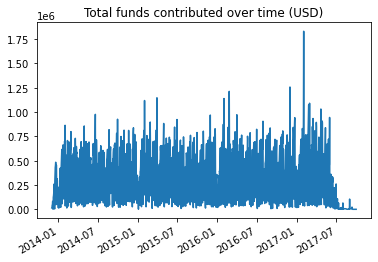

In [7]:
#convert the disbursement timestamp to datetime
loan_data['disbursed_time'] = pd.to_datetime(loan_data['disbursed_time'])
loan_data.loc[:,'disbursement_date'] = loan_data['disbursed_time'].dt.date

# create a pivot-table
tab1 = pd.pivot_table(loan_data, values='funded_amount', index=['disbursement_date'], aggfunc='sum')

# plot this table
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots()
ax.plot(tab1.index, tab1['funded_amount'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# declare the title and show the completed graph
ax.set_title('Total funds contributed over time (USD)')
plt.show()

hide_toggle()

In [8]:
tab1.describe()

,funded_amount
count,1.364000e+03
mean,3.855914e+05
std,2.651232e+05
min,2.500000e+01
25%,1.035125e+05
50%,4.285625e+05
75%,5.965188e+05
max,1.830375e+06


##### 3. How much money have Kiva donors given to individual loans?

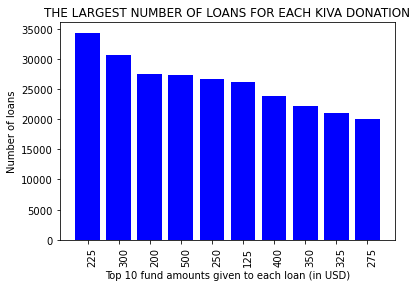

In [33]:
# create a pivot-table
loan_count_per_funded_amount = pd.pivot_table(loan_data, values='id', index=['funded_amount'], aggfunc='count')

# rename the column
loan_count_per_funded_amount.columns = ['number_of_loans']

# sort the results in descending order
loan_count_per_funded_amount = loan_count_per_funded_amount.sort_values(by=['number_of_loans'], ascending=False)

# and display top 10 results
amounts = ['225','300','200','500','250','125','400','350','325','275']
fig, ax = plt.subplots()
ax.bar(amounts,loan_count_per_funded_amount.iloc[0:10,0],color='blue')
plt.ylabel('Number of loans')
ax.set_xticklabels(labels=amounts, rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Top 10 fund amounts given to each loan (in USD)')
plt.title('THE LARGEST NUMBER OF LOANS FOR EACH KIVA DONATION')
plt.show()

hide_toggle() 

##### 4. How much money have Kiva donors given to individual countries?

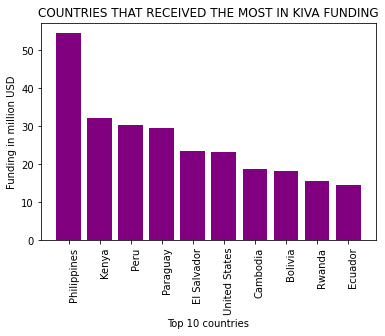

In [10]:
# create a pivot-table
tab2 = pd.pivot_table(loan_data, values='funded_amount', index=['country'], aggfunc='sum')

# sort the results in descending order
tab2 = tab2.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab2.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab2 = tab2.reset_index(level=['country'])

# and display top 10 results
fig, ax = plt.subplots()
ax.bar(tab2.iloc[0:10,0],(tab2.iloc[0:10,1]/1000000),color='purple')
plt.ylabel('Funding in million USD')
ax.set_xticklabels(labels=tab2.iloc[0:10,0], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Top 10 countries')
plt.title('COUNTRIES THAT RECEIVED THE MOST IN KIVA FUNDING')
plt.show()

hide_toggle()

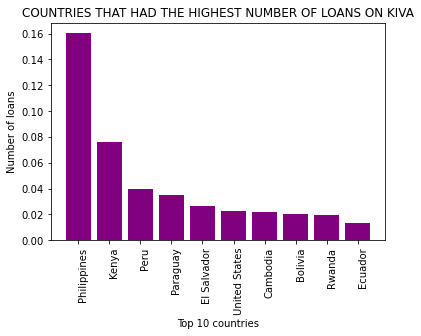

In [11]:
# create a pivot-table
loans_per_country = pd.pivot_table(loan_data, values='id', index=['country'], aggfunc='count')

# sort the results in descending order
loans_per_country = loans_per_country.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
loans_per_country.columns = ['number_of_loans']

# make some index entries into columns
loans_per_country = loans_per_country.reset_index(level=['country'])

# and display top 10 results
loans_per_country.head(10)


# and display top 10 results
fig, ax = plt.subplots()
ax.bar(loans_per_country.iloc[0:10,0],(loans_per_country.iloc[0:10,1]/1000000),color='purple')
plt.ylabel('Number of loans')
ax.set_xticklabels(labels=tab2.iloc[0:10,0], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Top 10 countries')
plt.title('COUNTRIES THAT HAD THE HIGHEST NUMBER OF LOANS ON KIVA')
plt.show()

hide_toggle()

In [12]:
# initial status message
print('The shape of tab2 before merge: ', tab2.shape)

# join the data, keeping only relevant entries
tab2 = tab2.merge(loans_per_country, on='country')

# final status message
print('The shape of tab2 after merge: ', tab2.shape)

hide_toggle() 

The shape of tab2 before merge:  (87, 2)
The shape of tab2 after merge:  (87, 3)


Countries that had the highest contribution per loan were:

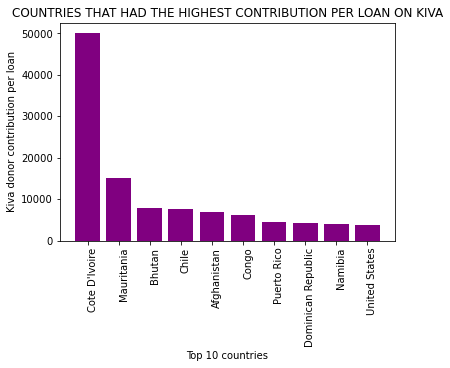

In [13]:
# add a calculated column to the newly merged tab2
tab2.loc[:, 'contribution_per_loan'] = tab2['sum_of_funded_amount']/tab2['number_of_loans']

# sort the results in descending order
tab2 = tab2.sort_values(by=['contribution_per_loan'], ascending=False)

# and display top 10 results
fig, ax = plt.subplots()
ax.bar(tab2.iloc[0:10,0], round(tab2.iloc[0:10,3], 2), color='purple')
plt.ylabel('Kiva donor contribution per loan')
ax.set_xticklabels(labels=tab2.iloc[0:10,0], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Top 10 countries')
plt.title('COUNTRIES THAT HAD THE HIGHEST CONTRIBUTION PER LOAN ON KIVA')
plt.show()

hide_toggle()

Countries that had the lowest contribution per loan were:

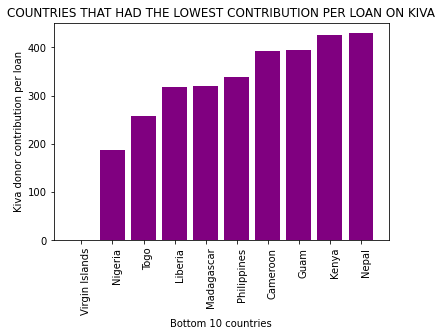

In [14]:
# add a calculated column to the newly merged tab2
tab2.loc[:, 'contribution_per_loan'] = tab2['sum_of_funded_amount']/tab2['number_of_loans']

# sort the results in descending order
tab2 = tab2.sort_values(by=['contribution_per_loan'], ascending=True)

# and display top 10 results
fig, ax = plt.subplots()
ax.bar(tab2.iloc[0:10,0], round(tab2.iloc[0:10,3], 2), color='purple')
plt.ylabel('Kiva donor contribution per loan')
ax.set_xticklabels(labels=tab2.iloc[0:10,0], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Bottom 10 countries')
plt.title('COUNTRIES THAT HAD THE LOWEST CONTRIBUTION PER LOAN ON KIVA')
plt.show()

hide_toggle()

##### 5. What is the geographical footprint of where funds given by KIVA donors end up?

In [15]:
# make a copy of the loan_data dataset and combine it with partner data
loan_data_copy = loan_data.copy()

# ensure that the common column is the same datatype and they share the same name
# the datatype chosen was float64 to preserve any decimal points
print(loan_data_copy.iloc[:,10].name) # original name; stays the same
print('')

print(regional_lts.iloc[:,0].name) #original name - will be changed
#change column name
regional_lts.columns = ['partner_id', 'Field Partner Name', 'sector',
                        'Loan Theme ID', 'Loan Theme Type', 'country',
                        'forkiva', 'region', 'geocode_old',
                        'ISO', 'number', 'amount',
                        'LocationName', 'geocode', 'names',
                        'geo', 'lat', 'lon',
                        'mpi_region', 'mpi_geo', 'rural_pct']
# confirm change
print(regional_lts.iloc[:,0].name)

# change the datatype
regional_lts.iloc[:,0] = regional_lts.iloc[:,0].astype('float64')

hide_toggle()

partner_id

Partner ID
partner_id


In [16]:
# create a pivot-table
tab3 = pd.pivot_table(loan_data_copy, values='funded_amount', index=['partner_id'], aggfunc='sum')

# sort the results in descending order
tab3 = tab3.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab3.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab3 = tab3.reset_index(level=['partner_id'])

hide_toggle()

In [17]:
# create a pivot-table
tab4 = pd.pivot_table(regional_lts, values='amount',
                      index=['partner_id', 'Field Partner Name',
                             'country'],
                      aggfunc='count')

# sort the results in descending order
tab4 = tab4.sort_values(by=['amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab4.columns = ['count_of_amount']

# make some index entries into columns
tab4 = tab4.reset_index(level=['partner_id', 'Field Partner Name', 'country'])

hide_toggle()

In [18]:
# create a pivot-table
tab5 = pd.pivot_table(loan_data_copy, values='id', index=['partner_id'], aggfunc='count')

# sort the results in descending order
tab5 = tab5.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
tab5.columns = ['number_of_loans']

# make some index entries into columns
tab5 = tab5.reset_index(level=['partner_id'])

hide_toggle()

In [19]:
# initial status message
print('The shape of tab3 before merge: ', tab3.shape)

# join the data, keeping only relevant entries
tab3 = tab3.merge(tab5, on='partner_id')

# final status message
print('The shape of tab3 after merge: ', tab3.shape)

hide_toggle()

The shape of tab3 before merge:  (366, 2)
The shape of tab3 after merge:  (366, 3)


In [20]:
# initial status message
print('The shape of tab3 before merge: ', tab3.shape)

# join the data, keeping only relevant entries
tab3 = tab3.merge(tab4, on='partner_id')

# final status message
print('The shape of tab3 after merge: ', tab3.shape)

hide_toggle()

The shape of tab3 before merge:  (366, 3)
The shape of tab3 after merge:  (331, 6)


In [21]:
percentage2 = tab3.shape[0]/366 * 100
percentage2 = round(percentage2, 0)

print('Out of the 366 partners that disbursed loans, KIVA had the contact details of '+str(percentage2)+'% of them.')

hide_toggle()

Out of the 366 partners that disbursed loans, KIVA had the contact details of 90.0% of them.


The partners that received the most funding by KIVA were:

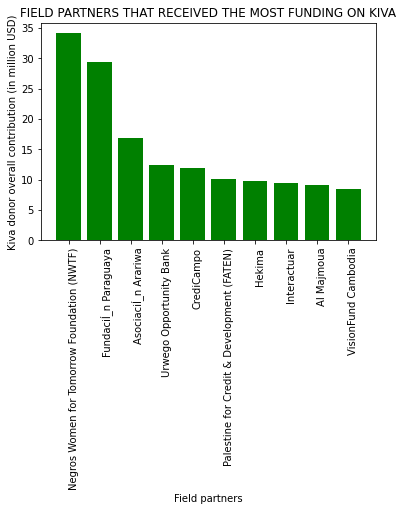

In [22]:
# to have more details of the partners that received the most funding by KIVA,
# sort the results in descending order
tab3 = tab3.sort_values(by=['sum_of_funded_amount'], ascending=False)

# drop the unecessary columns
tab3 = tab3.drop('count_of_amount',1)

# display top 10 results; do they match with the original tab3? They match!
fig, ax = plt.subplots()
ax.bar(tab3.iloc[0:10,3], (tab3.iloc[0:10,1]/1000000), color='green')
plt.ylabel('Kiva donor overall contribution (in million USD)')
ax.set_xticklabels(labels=tab3.iloc[0:10,3], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Field partners')
plt.title('FIELD PARTNERS THAT RECEIVED THE MOST FUNDING ON KIVA')
plt.show()

hide_toggle()

The partners that serviced the highest number of loans on KIVA were:

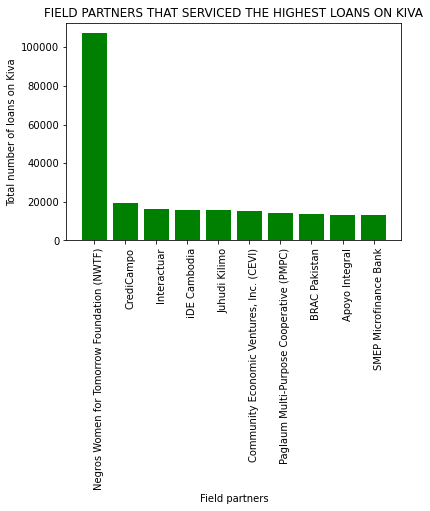

In [31]:
# sort the results in descending order
tab3 = tab3.sort_values(by=['number_of_loans'], ascending=False)

# display top 10 results in terms of number of loans
fig, ax = plt.subplots()
ax.bar(tab3.iloc[0:10,3], tab3.iloc[0:10,2], color='green')
plt.ylabel('Total number of loans on Kiva')
ax.set_xticklabels(labels=tab3.iloc[0:10,3], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Field partners')
plt.title('FIELD PARTNERS THAT SERVICED THE HIGHEST LOANS ON KIVA')
plt.show()

hide_toggle()

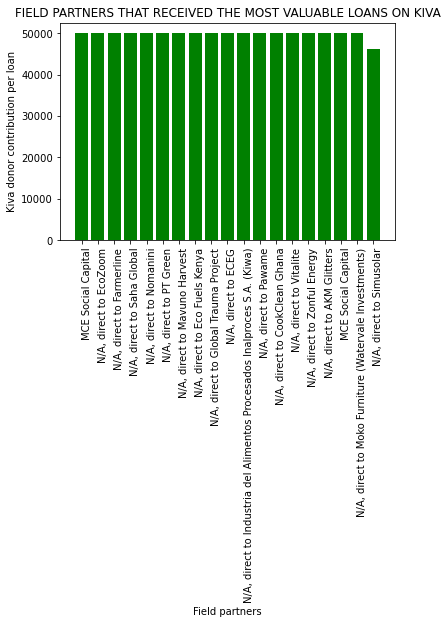

In [30]:
# add a calculated column to the newly merged tab3
tab3.loc[:, 'contribution_per_loan'] = tab3['sum_of_funded_amount']/tab3['number_of_loans']

# sort the results in descending order
tab3 = tab3.sort_values(by=['contribution_per_loan'], ascending=False)

# display top 20 results in terms of donor contribution per loan
fig, ax = plt.subplots()
ax.bar(tab3.iloc[0:20,3], tab3.iloc[0:20,5], color='green')
plt.ylabel('Kiva donor contribution per loan')
ax.set_xticklabels(labels=tab3.iloc[0:20,3], rotation = (90), fontsize = 10, va='top', ha='left')
plt.xlabel('Field partners')
plt.title('FIELD PARTNERS THAT RECEIVED THE MOST VALUABLE LOANS ON KIVA')
plt.show()

hide_toggle()

The per capita contribution shows most of the largest contributions per loan actually went directly to social impact businesses.

In [32]:
tab3.describe()

,partner_id,sum_of_funded_amount,number_of_loans,contribution_per_loan
count,331.000000,3.310000e+02,331.000000,331.000000
mean,319.592145,1.543571e+06,1987.135952,7611.247805
std,146.720761,3.325248e+06,6638.407914,13859.352972
min,9.000000,1.850000e+03,1.000000,106.578947
25%,200.000000,7.342500e+04,24.000000,730.639127
50%,340.000000,3.680000e+05,294.000000,1444.938849
75%,449.500000,1.335962e+06,1680.500000,4172.415865
max,536.000000,3.412790e+07,107188.000000,50000.000000


#### The characteristics of KIVA borrowers

In this section, we seek to understand KIVA borrower characteristics.

##### 1. What is the size of the shortfall for each individual borrower in a given sector?

In [ ]:
# create a pivot-table
tab6 = pd.pivot_table(loan_data_copy, values='funded_amount', index=['sector'], aggfunc='sum')

# sort the results in descending order
tab6 = tab6.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab6.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab6 = tab6.reset_index(level=['sector'])

# and display top 10 results
tab6.head(10)

In [ ]:
loans_by_sector = pd.pivot_table(loan_data_copy, values='id', index=['sector'], aggfunc='count')

# sort the results in descending order
loans_by_sector = loans_by_sector.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
loans_by_sector.columns = ['number_of_loans']

# make some index entries into columns
loans_by_sector = loans_by_sector.reset_index(level=['sector'])

# and display top 10 results
loans_by_sector.head(10)

In [ ]:
# create a pivot-table
loan_amounts_by_sector = pd.pivot_table(loan_data_copy, values='loan_amount', index=['sector'], aggfunc='sum')

# sort the results in descending order
loan_amounts_by_sector = loan_amounts_by_sector.sort_values(by=['loan_amount'], ascending=False)

# rename the aggregated column to an appropiate label
loan_amounts_by_sector.columns = ['sum_of_loan_amount']

# make some index entries into columns
loan_amounts_by_sector = loan_amounts_by_sector.reset_index(level=['sector'])

# and display top 10 results
loan_amounts_by_sector.head(10)

In [ ]:
# initial status message
print('The shape of tab6 before merge: ', tab6.shape)

# join the data, keeping only relevant entries
tab6 = tab6.merge(loans_by_sector, on='sector')

# final status message
print('The shape of tab6 after merge: ', tab6.shape)

In [ ]:
# initial status message
print('The shape of tab6 before merge: ', tab6.shape)

# join the data, keeping only relevant entries
tab6 = tab6.merge(loan_amounts_by_sector, on='sector')

# final status message
print('The shape of tab6 after merge: ', tab6.shape)

In [ ]:
# assess additional metrics
tab6.loc[:, 'donor_contribution_per_loan'] = tab6['sum_of_funded_amount']/tab6['number_of_loans']
tab6.loc[:, 'funding_gap_per_loan'] = (tab6['sum_of_loan_amount'] - tab6['sum_of_funded_amount'])/tab6['number_of_loans']

# sort the results in descending order
tab6 = tab6.sort_values(by=['funding_gap_per_loan'], ascending=False)

# display all results
tab6

It appears that the Entertainment sector has the highest funding gap and Manufacturing has the lowest funding gap.

##### 2. How were loans and funding distributed across the genders?

In [ ]:
# count frequency of female and male to identify number of borrowers
loan_data_copy.loc[:, 'number_of_all_borrowers'] = loan_data_copy['borrower_genders'].str.count('male') # counts both instances of female and male - they share the 'male' element
loan_data_copy.loc[:, 'number_of_female_borrowers'] = loan_data_copy['borrower_genders'].str.count('female')
loan_data_copy.loc[:, 'number_of_male_borrowers'] = loan_data_copy['number_of_all_borrowers'] - loan_data_copy['number_of_female_borrowers']

In [ ]:
# create a pivot-table
tab7 = pd.pivot_table(loan_data_copy, values=['term_in_months', 'number_of_all_borrowers', 'number_of_male_borrowers', 'number_of_female_borrowers', 'loan_amount', 'funded_amount'], index=['repayment_interval'], aggfunc='sum')

# sort the results in descending order
tab7 = tab7.sort_values(by=['number_of_all_borrowers'], ascending=False)

# make some index entries into columns
tab7 = tab7.reset_index(level=['repayment_interval'])

# and display all results
tab7

In [ ]:
# create a pivot-table
loan_repayment = pd.pivot_table(loan_data_copy, values='id', index=['repayment_interval'], aggfunc='count')

# sort the results in descending order
loan_repayment = loan_repayment.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
loan_repayment.columns = ['number_of_loans']

# make some index entries into columns
loan_repayment = loan_repayment.reset_index(level=['repayment_interval'])

# and display all results
loan_repayment

In [ ]:
# initial status message
print('The shape of tab7 before merge: ', tab7.shape)

# join the data, keeping only relevant entries
tab7 = tab7.merge(loan_repayment, on='repayment_interval')

# final status message
print('The shape of tab7 after merge: ', tab7.shape)

In [ ]:
tab7

In [ ]:
tab7.loc[:, 'female_pct_of_total_borrowers'] = round((tab7['number_of_female_borrowers']/tab7['number_of_all_borrowers'])*100, 2)
tab7.loc[:, 'male_pct_of_total_borrowers'] = round((tab7['number_of_male_borrowers']/tab7['number_of_all_borrowers'])*100, 2)
tab7.loc[:, 'million_USD_female_total_funding'] = round((tab7['female_pct_of_total_borrowers']/100*tab7['funded_amount'])/1000000, 2)
tab7.loc[:, 'million_USD_male_total_funding'] = round((tab7['male_pct_of_total_borrowers']/100*tab7['funded_amount'])/1000000, 2)
tab7.loc[:, 'million_USD_female_total_loan'] = round((tab7['female_pct_of_total_borrowers']/100*tab7['loan_amount'])/1000000, 2)
tab7.loc[:, 'million_USD_male_total_loan'] = round((tab7['male_pct_of_total_borrowers']/100*tab7['loan_amount'])/1000000, 2)

In [ ]:
# drop raw data columns
tab7 = tab7.drop(['funded_amount', 'loan_amount',
                  'number_of_all_borrowers', 'number_of_female_borrowers',
                  'number_of_male_borrowers', 'term_in_months'],1)

# display summary
tab7

#### Global welfare

In this section, we seek to explore the data to understand the financial well-being of various countries with the aid of an external dataset

What percentage of their monthly expenditure does the average citizen devote to loan repayments?

In [ ]:
# Made a copy of the data: 
expenditure = PCE_data.copy()

# Reference rows:
print('')
print(expenditure.iloc[0,0])
print(expenditure.iloc[18,0])
print(expenditure.iloc[49,0])
print(expenditure.iloc[76,0])
print(expenditure.iloc[87,0])
print(expenditure.iloc[132,0])
print(expenditure.iloc[140,0])

# Make a regional column for the data
expenditure.loc[:, 'region'] = 0
expenditure['region'].iloc[1:18] = 'East Asia and Pacific'
expenditure['region'].iloc[19:49] = 'Europe and Central Asia'
expenditure['region'].iloc[50:76] = 'Latin America and the Caribbean'
expenditure['region'].iloc[77:87] = 'Middle East and North Africa'
expenditure['region'].iloc[88:132] = 'Other High Income'
expenditure['region'].iloc[133:140] = 'South Asia'
expenditure['region'].iloc[141:186] = 'Sub-Saharan Africa'

# Delete header rows
expenditure = expenditure.drop(labels=[0,18,49,76,87,132,140], axis=0)

print('')
print(expenditure.iloc[0,0]) # should not have East Asia and Pacific
print(expenditure.iloc[18,0]) # should not have Europe and Central Asia
print(expenditure.iloc[49,0]) # should not have Latin America and the Caribbean
print(expenditure.iloc[76,0]) # should not have Middle East and North Africa
print(expenditure.iloc[87,0]) # should not have Other high Income
print(expenditure.iloc[132,0]) # should not have South Asia
print(expenditure.iloc[140,0]) # should not have Sub-Saharan Africa

print('')
print(expenditure.shape)

# Convert any 'n/a' strings to NaN values
expenditure = expenditure.replace('n/a', np.nan)

# Convert any numeric data stored as a string into a decimal
print('')
print(expenditure.dtypes)

expenditure['1960'] = expenditure['1960'].astype('float64')
expenditure['1961'] = expenditure['1961'].astype('float64')
expenditure['1962'] = expenditure['1962'].astype('float64')
expenditure['1963'] = expenditure['1963'].astype('float64')
expenditure['1964'] = expenditure['1964'].astype('float64')
expenditure['1965'] = expenditure['1965'].astype('float64')
expenditure['1966'] = expenditure['1966'].astype('float64')
expenditure['1967'] = expenditure['1967'].astype('float64')
expenditure['1968'] = expenditure['1968'].astype('float64')

print('')
print(expenditure.dtypes)


In [ ]:
YearlyExpenditure = expenditure.loc[:,'2014':'2017']

MonthlyExpenditure = YearlyExpenditure/12

MonthlyExpenditure.loc[:,'country'] = expenditure['Unnamed: 0']
MonthlyExpenditure.loc[:,'region'] = expenditure['region']

In [ ]:
MonthlyExpenditure

In [ ]:
# get the monthly repayment on each loan
loan_data_copy.loc[:, 'monthly_loan_repayment'] = loan_data_copy['loan_amount']/loan_data_copy['term_in_months']

# get the year that the loan was issued
loan_data_copy.loc[:,'disbursement_year'] = loan_data['disbursed_time'].dt.year

# create a pivot-table
tab8 = pd.pivot_table(loan_data_copy, values=['monthly_loan_repayment'], columns='disbursement_year', index=['country'], aggfunc='mean')

# drop level and rename columns
tab8 = tab8.droplevel('disbursement_year', axis=1)
tab8.columns = ['monthly_loan_repayment 2013', 'monthly_loan_repayment 2014',
                'monthly_loan_repayment 2015', 'monthly_loan_repayment 2016',
                'monthly_loan_repayment 2017']

# make some index entries into columns
tab8 = tab8.reset_index(level=['country'])

# and display all results
tab8

In [ ]:
# compare country/territory labels in the 2 datasets
print(tab8['country'].unique())
print('')
print(MonthlyExpenditure['country'].unique())

In [ ]:
tab8[tab8['country'].isin(MonthlyExpenditure['country']) == False]

In [ ]:
tab8.iloc[16,0] = 'Congo, Republic of'
tab8.iloc[18,0] = "Cote d'Ivoire"
tab8.iloc[21,0] = 'Egypt, Arab Republic of'
tab8.iloc[35,0] = 'Kyrgyz Republic'
tab8.iloc[48,0] = 'Myanmar'
tab8.iloc[54,0] = 'West Bank and Gaza'
# tab8.iloc[61,0] missing in other dataset
# tab8.iloc[62,0] missing in other dataset; only have American Samoa
# tab8.iloc[63,0] missing in other dataset
# tab8.iloc[65,0] missing in other dataset
# tab8.iloc[66,0] missing in other dataset
tab8.iloc[73,0] = 'Congo, Democratic Republic of'
# tab8.iloc[82,0] missing in other dataset

In [ ]:
tab8[tab8['country'].isin(MonthlyExpenditure['country']) == False]

In [ ]:
# initial status message
print('The shape of tab8 before merge: ', tab8.shape)

# join the data, keeping only relevant entries
tab8 = tab8.merge(MonthlyExpenditure, on='country')

# final status message
print('The shape of tab8 after merge: ', tab8.shape)

In [ ]:
# Get the share of wallet per month
tab8.loc[:, '% of monthly expenditure, 2014'] = (tab8['monthly_loan_repayment 2014']/tab8['2014']) * 100
tab8.loc[:, '% of monthly expenditure, 2015'] = (tab8['monthly_loan_repayment 2015']/tab8['2015']) * 100
tab8.loc[:, '% of monthly expenditure, 2016'] = (tab8['monthly_loan_repayment 2016']/tab8['2016']) * 100
tab8.loc[:, '% of monthly expenditure, 2017'] = (tab8['monthly_loan_repayment 2017']/tab8['2017']) * 100

# Round off values to 2 decimal places
tab8['% of monthly expenditure, 2014'] = round(tab8['% of monthly expenditure, 2014'], 2)
tab8['% of monthly expenditure, 2015'] = round(tab8['% of monthly expenditure, 2015'], 2)
tab8['% of monthly expenditure, 2016'] = round(tab8['% of monthly expenditure, 2016'], 2)
tab8['% of monthly expenditure, 2017'] = round(tab8['% of monthly expenditure, 2017'], 2)

In [ ]:
tab8.head(5)

In [ ]:
tab8 = tab8.drop(['monthly_loan_repayment 2013', 'monthly_loan_repayment 2014',
                  'monthly_loan_repayment 2015', 'monthly_loan_repayment 2016',
                  'monthly_loan_repayment 2017', '2014', '2015', '2016', '2017'], 1)
tab8.head(3)

In [ ]:
# sort the results in descending order
tab8 = tab8.sort_values(by=['% of monthly expenditure, 2017'], ascending=False)

# and display top 10 results
tab8.head(10)

What would the top 10 results be if we filtered out all null values?

In [ ]:
# drop null values
tab8 = tab8.dropna(axis=0)

# sort the results in descending order
tab8 = tab8.sort_values(by=['% of monthly expenditure, 2017'], ascending=False)

# and display top 10 results
tab8.head(10)

It appears that the debt burden for the countries above is quite high. Which 10 countries have the lowest debt burden?

In [ ]:
# sort the results in descending order
tab8 = tab8.sort_values(by=['% of monthly expenditure, 2017'], ascending=True)

# and display top 10 results
tab8.head(10)